In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
initial_image_png = "cropped_image.png"
points = np.genfromtxt('points.csv', delimiter=',', names=True)

# convert points to float tuples
points = [(float(x), float(y)) for x, y in points]
points = np.array(points)

points

array([[ 0.,  0.],
       [ 5.,  0.],
       [ 0., -4.],
       [-3.,  0.],
       [ 0.,  2.],
       [-7., -4.],
       [ 5., -7.],
       [ 8.,  2.],
       [-4.,  4.],
       [-3., -5.],
       [ 3., -4.],
       [ 3.,  6.],
       [ 2.,  2.],
       [-8.,  2.]])

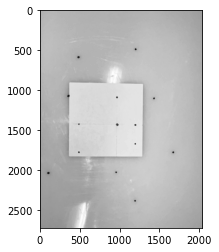

In [3]:
img = cv.imread(initial_image_png, cv.IMREAD_GRAYSCALE)

img = cv.medianBlur(img, 15)

plt.imshow(img, cmap="gray")

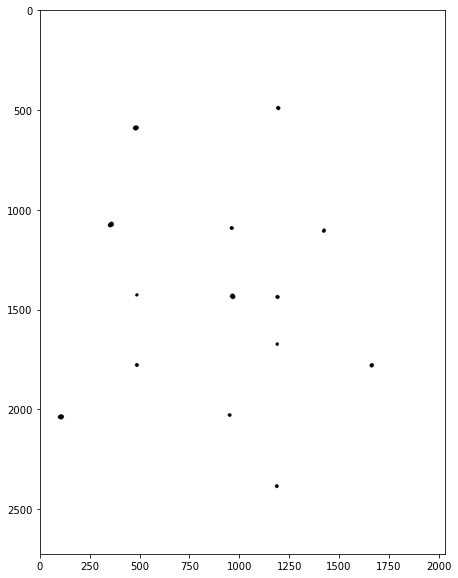

In [4]:
thresh, bwImage = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
# set the height of the plot to 10 inches

plt.figure(figsize=(10, 10))
plt.imshow(bwImage, cmap="gray")

In [5]:
params = cv.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 50

# params.filterByArea = True
params.minArea = 10

# # Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# # Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# # Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.1


detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(bwImage)
len(keypoints)

14

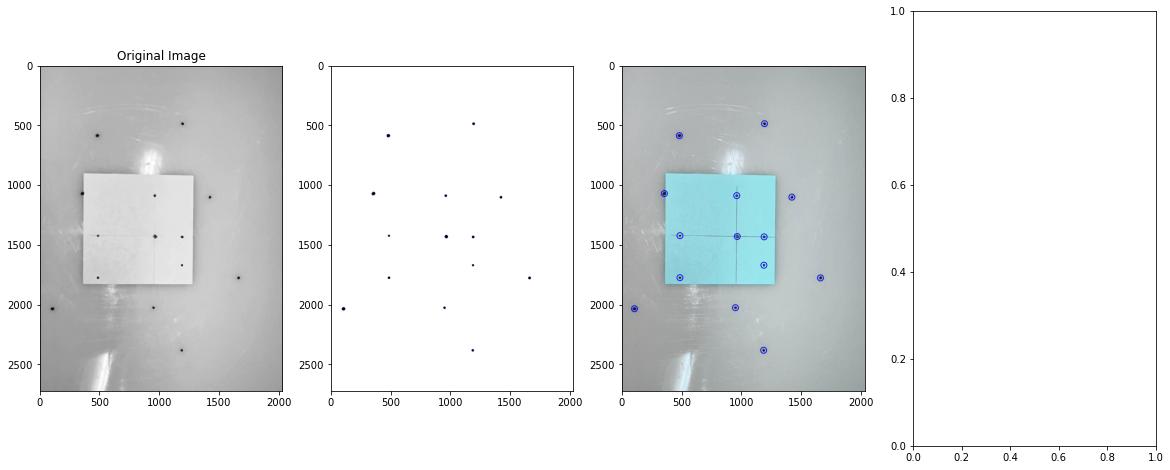

In [6]:
im_with_keypoints = cv.drawKeypoints(bwImage, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
circleImg = np.ones((bwImage.shape)) * 255
found_point_centers = []

for i, keypoint in enumerate(keypoints):
    center = (int(keypoint.pt[0]), int(keypoint.pt[1]))
    found_point_centers.append(center)
    cv.circle(circleImg, center, 25, 0, -1)

colored_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)

# Draw a circle around each found point with 25% transparency
for i, found_point in enumerate(found_point_centers):
    cv.circle(colored_img, found_point, 25, (0, 0, 255, 10), 5)

plt.subplots(1, 4, figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(im_with_keypoints)

plt.subplot(1, 4, 3)
plt.imshow(colored_img)


We now need to map each found point to one of the points in points 

In [7]:
# Map each point to the closest found point, knowing that points may be in different order
# and that the image is likely to be rotated and perspective distorted

# Find the euclidean distances between each point and other points
# make a np array of the distances

points_dists = np.zeros((len(points), len(points)))
for i, point in enumerate(points):
    for j, other_point in enumerate(points):
        points_dists[i, j] = np.sum(np.array(point) - np.array(other_point))
        # points_dists[i, j] = np.linalg.norm(np.array(point) - np.array(other_point))

found_point_dists = np.zeros((len(found_point_centers), len(found_point_centers)))
for i, point in enumerate(found_point_centers):
    for j, other_point in enumerate(found_point_centers):
        found_point_dists[i, j] = np.sum(np.array(point) - np.array(other_point))
        # found_point_dists[i, j] = np.linalg.norm(np.array(point) - np.array(other_point))

# For each point, find a unique distance index, calculated as the sum of the distances
# to all other points
point_dist_value = np.zeros(len(points))
for i, point in enumerate(points):
    point_dist_value[i] = np.sum(points_dists[i])

found_point_dist_value = np.zeros(len(found_point_centers))
for i, point in enumerate(found_point_centers):
    found_point_dist_value[i] = np.sum(found_point_dists[i])

# Normalize the distances
point_dist_value = point_dist_value / np.max(point_dist_value)
found_point_dist_value = found_point_dist_value / np.max(found_point_dist_value)

# apply linear sum assignment to find the best mapping
from scipy.optimize import linear_sum_assignment

original_point_index, found_point_index = linear_sum_assignment(np.abs(point_dist_value[:, None] - found_point_dist_value[None, :]))

mapping = {}

for original_point, found_point in zip(original_point_index, found_point_index):
    original_cood = points[original_point]
    found_coord = found_point_centers[found_point]
    mapping[found_coord] = original_cood

original_point_index, found_point_index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 7,  2,  8, 10,  6, 12,  1,  0,  9, 11,  4,  3,  5, 13]))

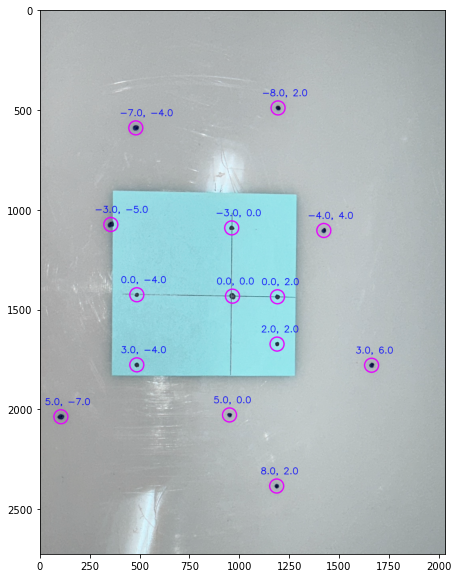

In [8]:
# On a color image, draw the coordinates of the original points on the found points

color_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)

combined = zip(original_point_index, found_point_index)

for found_coord, original_coord in mapping.items():
    text = f"{original_coord[0]}, {original_coord[1]}"

    text_point = (int(found_coord[0] - 80), int(found_coord[1] - 60))

    cv.putText(color_img, text, text_point, cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2, cv.LINE_AA)

    cv.circle(color_img, found_coord, 35, (230, 0, 255, 10), 5)

# make image size 10 inches by 10 inches
plt.figure(figsize=(10, 10))
plt.imshow(color_img)



In [9]:
#found_point_to_real_point = {found_point_centers[i]: points[found_point_index[i]] for i in range(len(points))}
found_point_to_real_point = mapping
found_point_to_real_point, mapping

({(963, 1433): array([0., 0.]),
  (948, 2028): array([5., 0.]),
  (484, 1426): array([ 0., -4.]),
  (959, 1091): array([-3.,  0.]),
  (1188, 1436): array([0., 2.]),
  (479, 590): array([-7., -4.]),
  (104, 2037): array([ 5., -7.]),
  (1184, 2384): array([8., 2.]),
  (1420, 1104): array([-4.,  4.]),
  (354, 1074): array([-3., -5.]),
  (484, 1777): array([ 3., -4.]),
  (1659, 1779): array([3., 6.]),
  (1186, 1673): array([2., 2.]),
  (1191, 490): array([-8.,  2.])},
 {(963, 1433): array([0., 0.]),
  (948, 2028): array([5., 0.]),
  (484, 1426): array([ 0., -4.]),
  (959, 1091): array([-3.,  0.]),
  (1188, 1436): array([0., 2.]),
  (479, 590): array([-7., -4.]),
  (104, 2037): array([ 5., -7.]),
  (1184, 2384): array([8., 2.]),
  (1420, 1104): array([-4.,  4.]),
  (354, 1074): array([-3., -5.]),
  (484, 1777): array([ 3., -4.]),
  (1659, 1779): array([3., 6.]),
  (1186, 1673): array([2., 2.]),
  (1191, 490): array([-8.,  2.])})

In [10]:
ordered_points = [points[fpi] for fpi in found_point_index]
ordered_points

[array([8., 2.]),
 array([ 0., -4.]),
 array([-4.,  4.]),
 array([ 3., -4.]),
 array([ 5., -7.]),
 array([2., 2.]),
 array([5., 0.]),
 array([0., 0.]),
 array([-3., -5.]),
 array([3., 6.]),
 array([0., 2.]),
 array([-3.,  0.]),
 array([-7., -4.]),
 array([-8.,  2.])]

In [11]:
def geometric_error(m, world_points, projections):
    error = 0
    n_points = len(world_points)
    for i in range(n_points):
        X, Y = world_points[i]
        u, v = projections[i]
        u_ = X * m[0] + Y * m[1] + m[2]
        v_ = X * m[3] + Y * m[4] + m[5]
        d = X * m[6] + Y * m[7] + m[8]
        u_ /= d
        v_ /= d
        error += np.sqrt(np.square(u - u_) + np.square(v - v_))
    return error

In [50]:
from scipy.optimize import minimize
m = np.array([120, 10, 2000, 10, 1000, 1400, 0, 0, 10])
#m = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1])
#m = np.random.random((9))
result = minimize(geometric_error, m,  method='Nelder-Mead', options={'maxiter':100000},args=(ordered_points, found_point_centers))
M_ = result.x.reshape(3, 3)
Minv = np.linalg.inv(M_)
print(result.fun)

# try adding a z component

5947.259235014275


In [13]:
result.x

array([ 5.96396629e+00,  2.47359662e+01,  2.88501978e+02,  3.23400923e+01,
       -5.25260737e+00,  4.29307720e+02,  1.61263020e-03, -1.70148617e-03,
        2.99586685e-01])

In [51]:
for pixel_point, real_point in mapping.items():
    x = real_point[0] * result.x[0] + real_point[1] * result.x[1] + result.x[2]
    y = real_point[0] * result.x[3] + real_point[1] * result.x[4] + result.x[5]
    d = real_point[0] * result.x[6] + real_point[1] * result.x[7] + result.x[8]
    x/=d
    y/=d
    sq_error = np.square(x - pixel_point[0]) + np.square(y - pixel_point[1])
    print(sq_error)

2.273293218676197e-14
18954.996813068898
20051.301388228916
2994.3859227569515
2684.2174220936745
28986.17171557748
127952.65603948125
40926.68434524624
39405.25122886509
28768.987541405724
33661.25495210293
22253.230985323666
3689.682335285859
33315.662739740386


In [54]:
errs = []
for pixel_point, real_point in mapping.items():
    x = pixel_point[0] * Minv[0, 0] + pixel_point[1] * Minv[0, 1] + Minv[0, 2]
    y = pixel_point[0] * Minv[1, 0] + pixel_point[1] * Minv[1, 1] + Minv[1, 2]
    sq_error = np.square(x - real_point[0]) + np.square(y - real_point[1])
    print(np.sqrt(sq_error), x, real_point[0], y, real_point[1])
    errs.append(np.sqrt(sq_error))

5.113427676571605e-09 4.026915689792077e-09 0.0 3.1513636145064083e-09 0.0
14.952668351641593 19.455791288821885 5.0 -3.8226154721872625 0.0
13.973335513922928 -1.905360499295064 0.0 -17.842821488135495 -4.0
8.406258851180914 -11.227152014199433 -3.0 1.7260236407163347 0.0
6.444001468991757 0.8855563836964393 0.0 8.382863371846714 2.0
24.248037549239687 -29.332794124080262 -7.0 -13.445296797919266 -4.0
30.733455522829725 16.798017156904493 5.0 -35.37872582656135 -7.0
23.976006683344654 31.95364731916142 8.0 3.035218135959017 2.0
15.743388622263758 -9.188045078591301 -4.0 18.863999245631323 4.0
19.167417715430332 -13.901212013682638 -3.0 -20.765578914538274 -5.0
17.094227995676 9.602880025313972 3.0 -19.767517437423777 -4.0
21.0534409442032 13.779363093019327 3.0 24.08459861041722 6.0
8.324455732799088 8.649080471564709 2.0 7.008621779490685 2.0
25.015770572365238 -30.120459177683276 -8.0 13.682211395864325 2.0


In [16]:
np.mean(errs)

16.366604680643018